In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LightSource
import rasterio as rio
import xarray as xr
from scipy import ndimage
from netCDF4 import Dataset
from landlab import RasterModelGrid
from landlab.components import ExponentialWeatherer
from landlab.components import DepthDependentDiffuser

## Coupling with Landlab components

This notebook gives one *very simplistic* example for how Ku can be used alongside landscape geomorphology models. We will use the active layer depth results from Ku to drive a depth-dependent hillslope diffusion model over the Eight Mile Lake study site.

The Eight Mile Lake DEM is a subset of the 2m ArcticDEM from the Polar Geospatial Center (see: https://www.pgc.umn.edu/data/arcticdem/). To run the following code cells, put the DEM of your choice in the data/ directory, and change the file names and paths accordingly. Alternatively, explore idealized examples by ignoring this section and altering the grid's topographic elevation field directly.

In [6]:
# Load a DEM
with rio.open('./data/eightmile-lake-dem-cropped.tif') as f:
    data = f.read(1)
    
    # ArcticDEM tiles are rotated, so let's rotate it back
    fine_dem = ndimage.rotate(data[:3280, :4530], 90)

From this point onwards, the computational requirements of almost every step will scale with the size of this DEM. To save time, we can rescale it with typical image processing tools. I'll use xarray's coarsen() method here.

In [7]:
# Coarsen the DEM 
xr_dem = xr.DataArray(fine_dem)
scale = 10
dem = xr_dem.coarsen(dim_0 = scale, dim_1 = scale).mean()

When visualizing DEMs, it is often helpful to use matplotlib's LightSource.hillshade(). For a bit of fun, mess with directional lighting using the 'azdeg' argument.

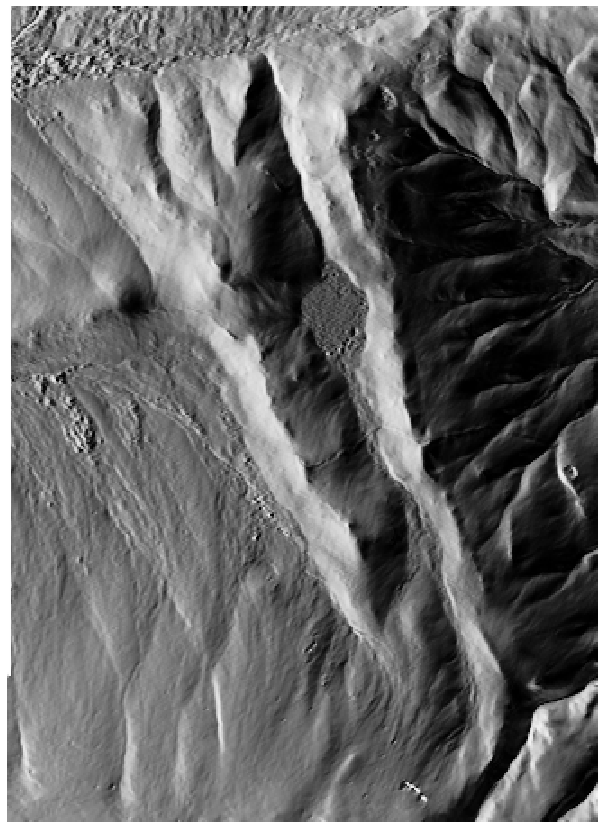

In [17]:
# Show the DEM
fig, ax = plt.subplots(figsize = (15, 15))

ls = LightSource(azdeg = 90, altdeg = 35)
shaded_dem = ls.hillshade(np.array(dem))

ax.imshow(shaded_dem, cmap = 'Greys')
plt.axis('off')
plt.show()